In [16]:
import os
from pprint import pprint
import pandas as pd 
import numpy as np
from nltk import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk import WordPunctTokenizer
import math
from num2words import num2words
import random
random.seed(0)
from decimal import Decimal
from word2number import w2n
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
sns.set(style = "darkgrid")

In [17]:
%run functions.ipynb

In [18]:
stop_ws = set(stopwords.words('english'))

In [19]:
path = "20_newsgroups/"
# rename_documents(path)
docs = collect_documents(path)

# print(docs)
token_docId = []

for k,v in docs.items():
    for i in tokenizeDocument(v[0]):
        token_docId.append([i,int(k)])
        
token_docId.sort()
inverted_index = makeIndex(token_docId)
V = len(inverted_index)
N = len(docs.keys())

print("No. of docs : ", N," Vocab : ", V )

No. of docs :  2000  Vocab :  30627


In [5]:
# inverted_index.keys()

In [20]:
def getValue(term, docid):
    """
        tf-idf
    """
    s = 0
    if term in inverted_index.keys():  
        
        if docid in inverted_index[term][1].keys():
            
            tf = 1 + math.log(inverted_index[term][1][docid], 10)
            idf = math.log(N/inverted_index[term][0], 10)
            
            s = tf * idf
    return s


In [7]:
def docsVec():
    """
        Create term doc matrix
    """
    global tdm
    k = 0
    for term, plist in inverted_index.items():  # every term,plist 
        for i in range(1,N+1):      # every doc id
            # calculate tf idf of term, for every doc id
            if i in plist[1].keys():
                tdm[k][i-1] = getValue(term, i) # tfidf, term, doc_id
        k+=1


In [8]:
def queryVec(query_tokens):
    
    query_vec = np.zeros((V,1))
    k= 0
    unq, cnt = np.unique(query_tokens, return_counts = True)

    for term in inverted_index.keys():
        if(term in query_tokens): 
            # Query vector # find index of  term in unq then get cnt[index]
            pos = np.nonzero(unq == term)[0][0]
            tf_query = 1 + math.log(cnt[pos], 10) 
            idf_query = math.log(N/inverted_index[term][0], 10)
                
            query_vec[k] = tf_query * idf_query
        else:
            query_vec[k] = 0
        k+=1
    return query_vec




In [9]:
def q2(query, opt_query=False):
    
    if(not opt_query):
        
        query_tokens = tokenizeDocument(query, True) 
        query_vec = queryVec(query_tokens)
    
        # normalize query vector
        euclid_dist_qy = np.linalg.norm(query_vec)
        # print(euclid_dist_qy)
        query_vec = (1/euclid_dist_qy)*query_vec
        # print(query_vec.T[0])
        query_vec_new = np.array(list(query_vec.flat))
        
    else:
        query_vec_new = query
        
    similarity = []
    
    for j in range(0, tdm.shape[1]):
        match_score = np.inner(tdm[:, j], query_vec_new.flatten())
        if([match_score, j+1] not in similarity) and (match_score > 0):
            similarity.append([match_score, j+1])
    
    top_ans = sorted(similarity, reverse=True)
    
    result_data = pd.DataFrame(top_ans[0:10], columns=["Similarity", "DocId"])
    
#     print(result_data)
    if(not opt_query):
        return result_data, query_vec
    else:
        return result_data, query

In [10]:
# Term Document Matrix
tdm = np.zeros((V,N))
docsVec()
# Normalize document vectors
euclid_dist = np.linalg.norm(tdm, axis=0)
# print(euclid_dist)
# new_dist = (1/euclid_dist)

for c in range(0, tdm.shape[1]):   
    tdm[:,c] = tdm[:,c]/euclid_dist[c] 

In [11]:

def Rocchio(result_df, query_v):
    
    alpha = 1
    beta = 0.75
    gamma = 0.15
    
    # no. of relevant docs
    r_docs = result_df.loc[result_df['relevance'] == 1]
    nr_docs = result_df.loc[result_df['relevance'] == 0]
    
    
    sum_dj_r = np.zeros((V,1))
    sum_dj_nr = np.zeros((V,1))
    
    for j in r_docs.iloc[:,1]:
        sum_dj_r +=tdm[:, j-1][np.newaxis].T
    
    for j in nr_docs.iloc[:,1]:
        sum_dj_nr +=tdm[:, j-1][np.newaxis].T
        
    opt_query = alpha*query_v + beta*((1/r_docs.shape[0])*sum_dj_r) - gamma*((1/nr_docs.shape[0])*sum_dj_nr)
    
    mean_r = (1/r_docs.shape[0])*sum_dj_r
    mean_nr = (1/nr_docs.shape[0])*sum_dj_nr
    return (opt_query, mean_r, mean_nr)
    

In [12]:
def drawTSNE(opt_q, qvec, mean_r, mean_nr):
    
    highDim_data = np.zeros((4, opt_q.shape[0]))
    
    highDim_data[0] = opt_q.T
    highDim_data[1] = qvec.T
    highDim_data[2] = mean_r.T
    highDim_data[3] = mean_nr.T
    
#   print(highDim_data.shape, highDim_data)
    lowDim_data = TSNE(n_components=2, init='pca').fit_transform(highDim_data)

    points = pd.DataFrame(lowDim_data, columns=['x1', 'x2'])

    print(points)
            
    ax = sns.scatterplot(x = 'x1', y = 'x2', data =  points, style = ['g', 'r', 'c', 'm'])
    ax.set_title('TSNE Visualization')
    plt.quiver( 0,0,points['x1'].values, points['x2'].values, color =  ['g', 'r', 'c', 'm'], angles='xy', scale_units='xy', scale=1)
    
    plt.show()

Search : LightWave3D is part of a suite argument against automobiles
   Similarity  DocId
0    0.129625      8
1    0.117137   1014
2    0.058779    908
3    0.057143    837
4    0.047351    452
5    0.044371    590
6    0.037278    874
7    0.033305   1263
8    0.032167   1969
9    0.031688   1224
Relevants : 1


           x1          x2
0 -125.296547  181.259140
1 -283.091858   16.348186
2 -121.739929   19.907124
3 -286.648468  177.700180


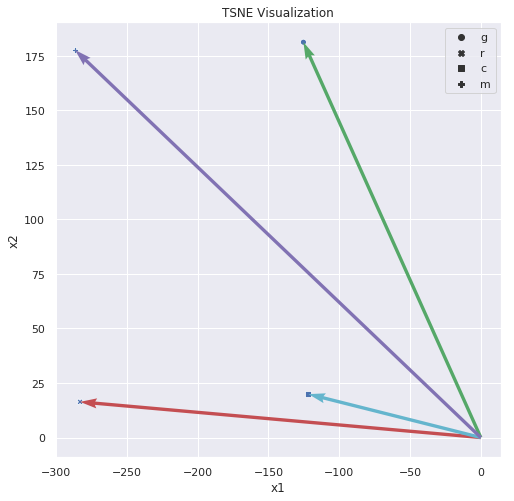

1115
   Similarity  DocId
0    0.863978   1014
1    0.118763      8
2    0.111742   1558
3    0.099068   1324
4    0.078965   1469
5    0.052986    837
6    0.051881   1737
7    0.049444    908
8    0.046135   1333
9    0.044787    337
Relevants : 0,1,2,3


           x1          x2
0 -236.959000  454.839874
1 -205.829971  169.830673
2   79.178886  200.962128
3   48.049873  485.971222


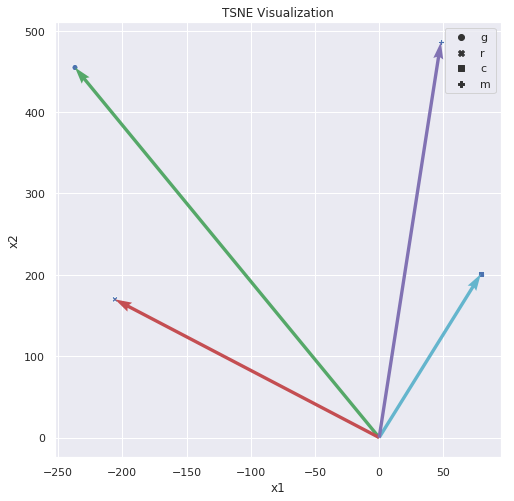

1606
   Similarity  DocId
0    1.102397   1014
1    0.366618   1558
2    0.354941   1324
3    0.310880      8
4    0.175137   1469
5    0.096755   1643
6    0.086841   1800
7    0.084835   1343
8    0.080293   1427
9    0.077965   1852


In [ ]:
run = True

tk = 4

while(run):
    
    query = input('Search : ')

    if(query == ""):
        run = False
        print("Exiting...")  
    else:
        result_df, qvec = q2(query)
        
        print(result_df)
        
        while(1):
            
            tk = result_df.shape[0] 
           
            relv = np.zeros((tk,)) # 0 nr, 1 r
            
            relevant = input('Relevants : ')
            # taking feedback
            if(relevant == ""): # assumption atleast one doc is relevant to the user, and at least one doc is irrelevant
                break
                
            kl = relevant.split(',')
            
            for k in kl:
                relv[int(k)] = 1
            
            relv_df = pd.Series(data = relv, name = "relevance")
            result_df = pd.concat([result_df, relv_df], axis = 1)

            print('\n')
            # find optimal query - Rocchio part and get new results
            opt_q, mean_r, mean_nr = Rocchio(result_df, qvec)
            
            drawTSNE(opt_q, qvec, mean_r, mean_nr)
            
            print(np.count_nonzero(opt_q))
            updated_results, updated_query =  q2(opt_q, True) # updated_query == opt_q
            print(updated_results)
            result_df = updated_results
            
            qvec = updated_query
            

In [14]:
# pprint(inverted_index['signal'])
